In [4]:
from keras.models import Sequential
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dropout

import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
import joblib
from sklearn import preprocessing

Using TensorFlow backend.


In [8]:
group = 'C4v'
J = '4'
w_sign = 1
dir = './TrainingData_{}_{}/Experimental_network_{}/'.format(group, J, w_sign)
# dir = './Experimental_network/'.format(group, J)
data = dir + 'generated_data_{}.csv'
targets = dir + 'generated_targets_{}.csv'

In [17]:
def cwt(data, channels=6, wavelet='morl'):
    """
    Applies the continuous wavelet transformation on each dataset (susc, spec heat, magnetization at 4 temps) individually
    and combines each convolution into a multi-channel image to be fed to the CNN
    Args:
        data: 1D array containing each dataset
        channels: number of channels in the output image (susc, spec heat, magnetization at 4 temps)
        waveletname: mother wavelet function to be used Can be any from 
            https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html, specifically pywt.wavelist()

    Returns:
        Input data reshaped into a (shape x shape) image with 'channels' channels
    """
    shape = data.shape[1]//channels
    size = data.shape[0]
    scales = np.linspace(1, 200, shape)

    data_cwt = np.ndarray(shape=(size, shape, shape, channels), dtype=np.float16)
    for i in range(size):
        if (i % 1000 == 0):
            print('.', end='')

        # generating each of the channels
        for j in range(channels):
            signal = data[i][j*shape: shape+(j*shape)]
            coeff, freq = pywt.cwt(signal, scales, wavelet, 1)
            data_cwt[i, :, :, j] = coeff

    return data_cwt

In [10]:
x_train = np.array(pd.read_csv(data.format(1000), header=None))
y_train = np.array(pd.read_csv(targets.format(1000), header=None))
channels = len(x_train[0])//64
# x_train = cwt(x_train, channels=channels)

In [11]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train = np.array(pd.read_csv(data.format(50000), header=None))
y_train = np.array(pd.read_csv(targets.format(50000), header=None))
channels = len(x_train[0])//64

x_test = np.array(pd.read_csv(data.format(10000), header=None))
y_test = np.array(pd.read_csv(targets.format(10000), header=None))

FileNotFoundError: File b'./TrainingData_C4v_4/Experimental_network_1/generated_data_50000.csv' does not exist

In [ ]:
x_val = x_test[:2000]
x_test = x_test[2000:]
y_val = y_test[:2000]
y_test = y_test[2000:]

x_val = cwt(x_val, channels=channels)
print('x_val finished')
x_train = cwt(x_train, channels=channels)
print('x_train finished')
x_test = cwt(x_test, channels=channels)

# center the image data for each channel (mean of zero)
x_mean = np.mean(x_train, axis=(0,1,2), keepdims=True)
x_train -= x_mean
x_val -= x_mean
x_test -= x_mean

In [ ]:
# normalize each of the targets (mean of zero and std of one)
y_mean = np.mean(y_train, axis=(0,), keepdims=True)
y_train -= y_mean
y_val -= y_mean
y_test -= y_mean
y_std = np.std(y_train, axis=(0,), keepdims=True)
y_train /= y_std
y_val /= y_std
y_test /= y_std

In [12]:
x_mean = np.load(dir + 'x_mean_{}_{}.npy'.format(group, J))
y_mean = np.load(dir + 'y_mean_{}_{}.npy'.format(group, J))
y_std = np.load(dir + 'y_std_{}_{}.npy'.format(group, J))

In [6]:
model = models.Sequential()

model.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=(64, 64, channels)))
model.add(layers.Conv2D(96, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Flatten())

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(len(y_train[0])))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 96)        4416      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 96)        83040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       221440    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 256)      

In [14]:
from keras.models import load_model
model = load_model(dir + '{}_{}_{}_model.h5'.format(group, J, w_sign))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(x_train,
    y_train,
    epochs=2,
    batch_size=256,
    validation_data=(x_val, y_val))

average_mae_history = history.history['val_mae']
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
model.evaluate(example_x, (y_real-y_mean)/y_std)

In [18]:
y_real = np.array(pd.read_csv(dir + 'generated_targets_1000.csv', header=None))
example_x = np.array(pd.read_csv(dir + 'generated_data_1000.csv', header=None))

In [19]:
from sklearn import metrics
example_x = cwt(example_x, channels=channels)
example_x -= x_mean
y_pred = model.predict(example_x)
y_pred = (y_pred * y_std) + y_mean

.

In [20]:
for i in range(len(y_pred[0])-1):
    print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,i], y_pred[:,i])))
    print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,i], y_pred[:,i])))
    print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,i], y_pred[:,i])))
    print('r^2 score: {}'.format(metrics.r2_score(y_real[:,i], y_pred[:,i])))
    print()

Mean absolute error: 2.304112455835571
Mean squared error: 11.2854845965977
Explained varience score: 0.949434364092854
r^2 score: 0.945806976344643

Mean absolute error: 0.03412015623960784
Mean squared error: 0.001978288136592911
Explained varience score: 0.9701975861317407
r^2 score: 0.9686293835435044

Mean absolute error: 0.19842201277827662
Mean squared error: 0.06430296823064902
Explained varience score: 0.008670807865157393
r^2 score: 0.008039931921746346

Mean absolute error: 0.06919400032469311
Mean squared error: 0.008739604272504435
Explained varience score: 0.8761968309805197
r^2 score: 0.8746440786931019

Mean absolute error: 0.19707940915054478
Mean squared error: 0.06449746781768366
Explained varience score: 0.02818406208563773
r^2 score: 0.025578332545019955



In [21]:
res = pd.DataFrame()

for i in range(len(y_pred[0])):
    res['pred{}'.format(i)] = np.array(y_pred[:,i])
    res['real{}'.format(i)] = pd.DataFrame(y_real).reset_index(drop=True)[i]
    res['error{}'.format(i)] = res['pred{}'.format(i)] - res['real{}'.format(i)]

Text(0, 0.5, 'Absolute error')

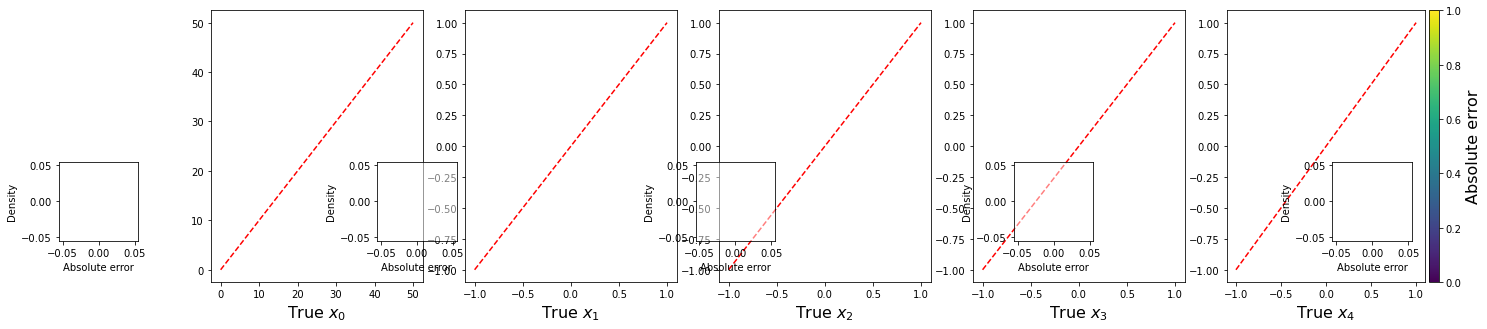

In [26]:
bad = pd.DataFrame()
bad = res.loc[abs(res['error3']) >= 0.5]
fig, ax = plt.subplots(ncols=len(y_pred[0])-1, nrows=1, figsize=(4*len(y_pred[0])-2,5)) #4 to tetra, 3.65 for hex
zs = np.array([])
for i in range(1, len(y_pred[0])-1):
    zs = np.concatenate([zs, bad['error{}'.format(i)]], axis=0)
# min_, max_ = zs.min(), zs.max()
# norm = plt.Normalize(min_, max_)

for i in range(0, len(y_pred[0])-1):
    p = ax[i].scatter(bad['real{}'.format(i)], bad['pred{}'.format(i)], c=bad['real{}'.format(i)]-bad['pred{}'.format(i)])
    if (i > 0):
        ax[i].plot([-1, 1], [-1, 1], c='r', ls='--')
    else:
        ax[i].plot([0, 50], [0, 50], c='r', ls='--')
    ax2 = plt.axes([0.23+((i-1)*0.201), 0.24, 0.20/(len(y_pred[0])-2), 0.22]) # 0.23+((i-1)*0.201) for tetragonal
                                                                             # 0.27+((i-1)*0.27) for hex
    sns.distplot(bad['error{}'.format(i)], color="g", kde=True, ax=ax2, norm_hist=True)
    ax2.set_xlabel('Absolute error')
    ax2.set_ylabel('Density')
    ax2.patch.set_alpha(0.5)
    
    ax[i].set_xlabel('True $x_{}$'.format(i), fontsize=16)

cb = colorbar(p, False)
cb.ax.set_ylabel('Absolute error', fontsize=16)

Text(0, 0.5, 'Absolute error')

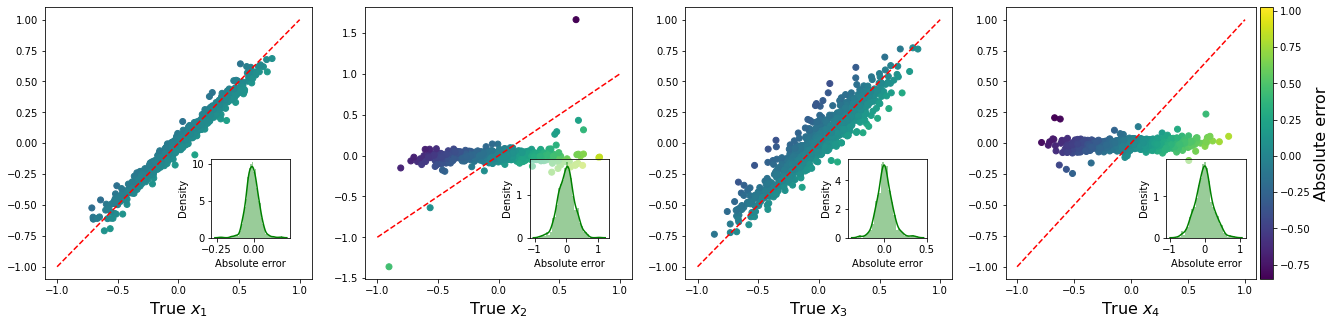

In [27]:
fig, ax = plt.subplots(ncols=len(y_pred[0])-2, nrows=1, figsize=(4*len(y_pred[0])-2,5)) #4 to tetra, 3.65 for hex
zs = np.array([])
for i in range(1, len(y_pred[0])-1):
    zs = np.concatenate([zs, res['error{}'.format(i)]], axis=0)
min_, max_ = zs.min(), zs.max()
norm = plt.Normalize(min_, max_)

for i in range(1, len(y_pred[0])-1):
    p = ax[i-1].scatter(res['real{}'.format(i)], res['pred{}'.format(i)], c=res['real{}'.format(i)]-res['pred{}'.format(i)], norm=norm)
    if (i > 0):
        ax[i-1].plot([-1, 1], [-1, 1], c='r', ls='--')
    else:
        ax[i-1].plot([0, 50], [0, 50], c='r', ls='--')
    ax2 = plt.axes([0.23+((i-1)*0.201), 0.24, 0.20/(len(y_pred[0])-2), 0.22]) # (0.23+((i-1)*0.201) for tetragonal
                                                                             # 0.27+((i-1)*0.27) for hex
    sns.distplot(res['error{}'.format(i)], color="g", kde=True, ax=ax2, norm_hist=True)
    ax2.set_xlabel('Absolute error')
    ax2.set_ylabel('Density')
    ax2.patch.set_alpha(0.5)
    
    ax[i-1].set_xlabel('True $x_{}$'.format(i), fontsize=16)

cb = colorbar(p, False)
cb.ax.set_ylabel('Absolute error', fontsize=16)

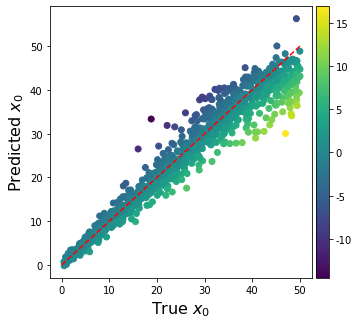

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
for i in range(1):
    i = 0
    p = ax.scatter(res['real{}'.format(i)], res['pred{}'.format(i)], c=res['real{}'.format(i)]-res['pred{}'.format(i)])

    ax.plot([0, 50], [0, 50], c='r', ls='--')
    
ax.set_xlabel(f'True $x_{i}$', fontsize=16)
ax.set_ylabel(f'Predicted $x_{i}$', fontsize=16)
# ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])
ax2.patch.set_alpha(0.5)
# sns.distplot(res['error0'], color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')
cb = colorbar(p, True)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

last_real = [0 if i < 0 else 1 for i in y_real[:,len(y_pred[0])-1]]
last_pred = [0 if i < 0 else 1 for i in y_pred[:,len(y_pred[0])-1]]
report = classification_report(last_real, last_pred)
print(report)

In [ ]:
fig, ax = plt.subplots(ncols=len(y_pred[0]), nrows=1, figsize=(3.5*len(y_pred[0]),3.5))
for i in range(len(y_pred[0])):
    sns.distplot(y_real[:,i], color="g", kde=True, norm_hist=True, ax=ax[i])

In [12]:
for i in range(len(y_pred[0])):
    print('Mean absolute error: {}'.format(metrics.mean_absolute_error(y_real[:,i], y_pred[:,i])))
    print('Mean squared error: {}'.format(metrics.mean_squared_error(y_real[:,i], y_pred[:,i])))
    print('Explained varience score: {}'.format(metrics.explained_variance_score(y_real[:,i], y_pred[:,i])))
    print('r^2 score: {}'.format(metrics.r2_score(y_real[:,i], y_pred[:,i])))
    print()

Mean absolute error: 1.075751154615275
Mean squared error: 4.174134984281329
Explained varience score: 0.9954420939936527
r^2 score: 0.9950407568672798

Mean absolute error: 0.04256436050027688
Mean squared error: 0.010220558298691623
Explained varience score: 0.9678151376974116
r^2 score: 0.9677871157918996



In [25]:
def colorbar(mappable, ints):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(position="right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if (ints):
        cax.set_yticklabels(['{:,}'.format(int(x)) for x in cax.get_yticks().tolist()])
    plt.sca(last_axes)
    return cbar

NameError: name 'ax2' is not defined

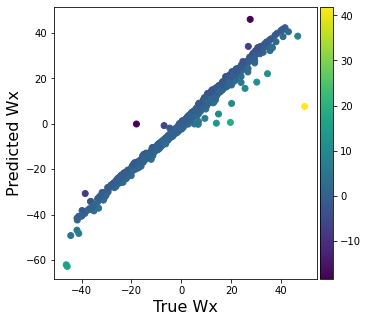

In [13]:
import matplotlib.pyplot as plt

wx_real = [y_real[:,0][i]*y_real[:,1][i] for i in range(len(y_real))]
wx_pred = [y_pred[:,0][i]*y_pred[:,1][i] for i in range(len(y_pred))]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
# ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])
# ax3 = plt.axes([0.735, 0.22, 0.12, 0.24])
# fig.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=None, hspace=None)
error0 = y_real[:,0]-y_pred[:,0]
error1 = y_real[:,1]-y_pred[:,1]
error2 = [wx_real[i]-wx_pred[i] for i in range(len(wx_real))]
# df['Target'] = df['Target'].astype('category')

p1 = ax.scatter(wx_real, wx_pred, c=error2)
cb = colorbar(p1, False)
# cb.ax.set_ylabel('Absolute error')

ax.set_xlabel('True Wx', fontsize=16)
ax.set_ylabel('Predicted Wx', fontsize=16)
# legend1 = ax[0].legend(*p1.legend_elements(num=5), loc='upper left', title='Absolute error')
# ax.plot([0, 50], [0, 50], c='r', ls='--')





# sns.distplot(error2, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')



Text(0, 0.5, 'Density')

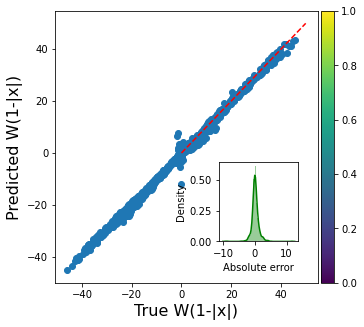

In [14]:
import matplotlib.pyplot as plt

w1x_real = [y_real[:,0][i]*(1-abs(y_real[:,1][i])) for i in range(len(y_real))]
w1x_pred = [y_pred[:,0][i]*(1-abs(y_pred[:,1][i])) for i in range(len(y_pred))]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])
# ax3 = plt.axes([0.735, 0.22, 0.12, 0.24])
# fig.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=None, hspace=None)
error0 = y_real[:,0]-y_pred[:,0]
error1 = y_real[:,1]-y_pred[:,1]
error3 = [w1x_real[i]-w1x_pred[i] for i in range(len(wx_real))]
# df['Target'] = df['Target'].astype('category')

p1 = ax.scatter(w1x_real, w1x_pred) # error is found by mse generated curves vs target generated curves
cb = colorbar(p1, False)
# cb.ax.set_ylabel('Absolute error')

ax.set_xlabel('True W(1-|x|)', fontsize=16)
ax.set_ylabel('Predicted W(1-|x|)', fontsize=16)
# legend1 = ax[0].legend(*p1.legend_elements(num=5), loc='upper left', title='Absolute error')
ax.plot([0, 50], [0, 50], c='r', ls='--')





sns.distplot(error3, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')



Text(0, 0.5, 'Density')

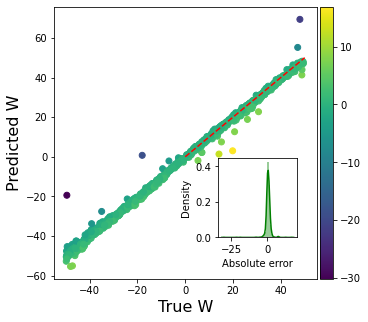

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])
# ax3 = plt.axes([0.735, 0.22, 0.12, 0.24])
# fig.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=None, hspace=None)
error0 = y_real[:,0]-y_pred[:,0]
error1 = y_real[:,1]-y_pred[:,1]
# df['Target'] = df['Target'].astype('category')

p1 = ax.scatter(y_real[:,0], y_pred[:,0], c=error0)
cb = colorbar(p1, False)
# cb.ax.set_ylabel('Absolute error')

ax.set_xlabel('True W', fontsize=16)
ax.set_ylabel('Predicted W', fontsize=16)
# legend1 = ax[0].legend(*p1.legend_elements(num=5), loc='upper left', title='Absolute error')
ax.plot([0, 50], [0, 50], c='r', ls='--')





sns.distplot(error0, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')



https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/
https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/
https://stackoverflow.com/questions/54525136/numpy-normalize-rgb-image-dataset

Text(0, 0.5, 'Density')

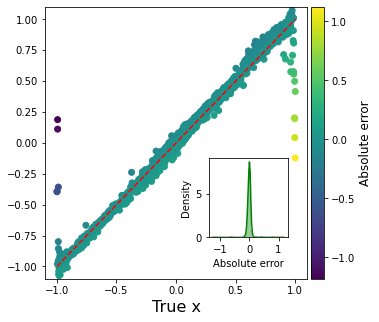

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
ax2 = plt.axes([0.58, 0.24, 0.22, 0.22])

p2 = ax.scatter(y_real[:,1], y_pred[:,1], c=error1)
cb2 = colorbar(p2, False)
cb2.ax.set_ylabel('Absolute error', fontsize=12)
# legend2 = ax[1].legend(*p2.legend_elements(num=6), loc='upper left', title='Absolute error')
ax.set_xlabel('True x', fontsize=16)
# ax[1].set_ylabel('Predicted x', fontsize=14)
ax.set_ylim(-1.1, 1.1)
ax.plot([-1, 1], [-1, 1], c='r', ls='--')

sns.distplot(error1, color="g", kde=True, ax=ax2, norm_hist=True)
ax2.set_xlabel('Absolute error')
ax2.set_ylabel('Density')